In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [2]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train\AKIEC 3856
data/train\BCC 4773
data/train\BKL 3275
data/train\DF 4152
data/train\MEL 3308
data/train\NV 4975
data/train\VASC 3488


In [5]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation\AKIEC 1552
data/validation\BCC 1692
data/validation\BKL 1479
data/validation\DF 1632
data/validation\MEL 1664
data/validation\NV 1730
data/validation\VASC 1484


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = True)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [7]:
## Intilizing variables
output_classes = 7

batch_size = 32 
epochs = 50
droput_rate= 0.5


adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

xception_weights = 'pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
model = Sequential()

model.add(Xception(weights = xception_weights , include_top=False,pooling = 'avg'))
model.add(Dropout(rate=droput_rate))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy'])

In [9]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50


c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2048/2048 [==============================] - 1247s 609ms/step - loss: 0.8035 - acc: 0.7252 - val_loss: 0.4866 - val_acc: 0.8336
Epoch 2/50
2048/2048 [==============================] - 1226s 599ms/step - loss: 0.1786 - acc: 0.9446 - val_loss: 0.3417 - val_acc: 0.8766
Epoch 3/50
2048/2048 [==============================] - 1228s 599ms/step - loss: 0.0551 - acc: 0.9854 - val_loss: 0.3219 - val_acc: 0.8852
Epoch 4/50
2048/2048 [==============================] - 1228s 599ms/step - loss: 0.0193 - acc: 0.9959 - val_loss: 0.3270 - val_acc: 0.8854
Epoch 5/50
2048/2048 [==============================] - 1226s 598ms/step - loss: 0.0095 - acc: 0.9982 - val_loss: 0.3290 - val_acc: 0.8895
Epoch 6/50
2048/2048 [==============================] - 1225s 598ms/step - loss: 0.0062 - acc: 0.9987 - val_loss: 0.3657 - val_acc: 0.8895
Epoch 7/50
2048/2048 [==============================] - 1228s 600ms/step - loss: 0.0041 - acc: 0.9992 - val_loss: 0.3651 - val_acc: 0.8914
Epoch 8/50
2048/2048 [================

In [10]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.4533282817527652
Test Accuracy:  0.9025


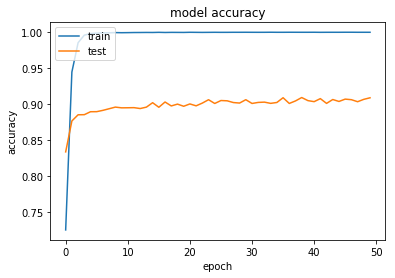

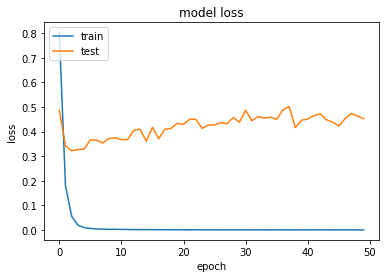

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [13]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

352/351 [==============================] - 43s 123ms/step
No of errors = 9687/11233


Confusion matrix
[[186 210 229 224 247 278 178]
 [230 261 251 221 260 303 166]
 [179 222 197 217 240 267 157]
 [206 228 251 196 278 287 186]
 [221 247 215 234 255 312 180]
 [241 289 226 234 254 319 167]
 [180 233 215 195 239 290 132]]


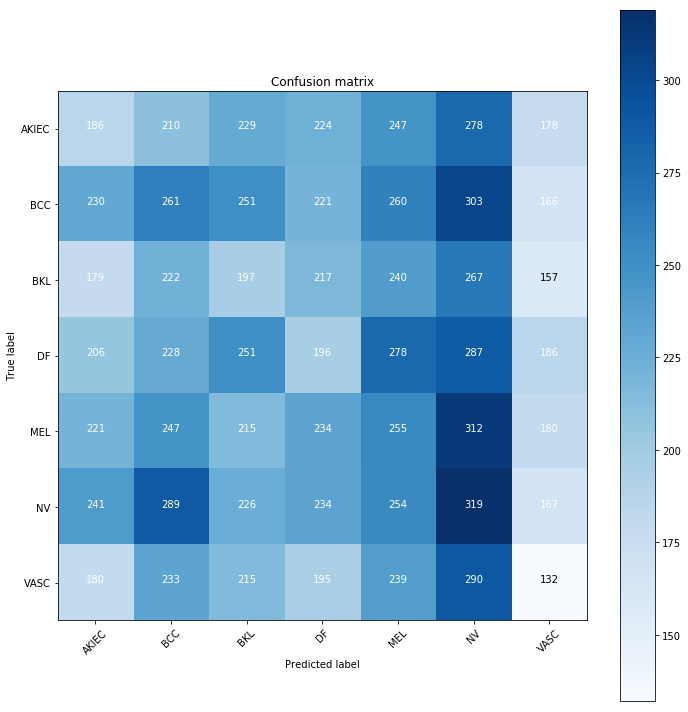

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix')

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [16]:
predict_and_report(train_generator, model)

c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Accuracy: 0.3100945125238078
Area Under the Receiver Operating Characteristic Curve: 0.1672594777478963
              precision    recall  f1-score   support

           0       1.00      0.17      0.29     23054
           1       1.00      1.00      1.00      4773
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31     27827
   macro avg       0.29      0.17      0.18     27827
weighted avg       1.00      0.31      0.41     27827



c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [17]:
predict_and_report(validation_generator, model)

Accuracy: 0.2713433633045491
Area Under the Receiver Operating Characteristic Curve: 0.16740882883699887
              precision    recall  f1-score   support

           0       0.99      0.15      0.26      9541
           1       0.95      0.95      0.95      1692
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

   micro avg       0.27      0.27      0.27     11233
   macro avg       0.28      0.16      0.17     11233
weighted avg       0.98      0.27      0.37     11233



In [18]:
model.save('models/2.Xception-Adam-without-Dropout-Model.h5')
model.save_weights('models/2.Xception-Adam-without-Dropout-Weights.h5')

In [19]:
##########################################################################################################

In [ ]:
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
#print (predictions)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))



In [ ]:
print(str(len(errors)/validation_generator.samples)) + "%")

# Misclassified Images

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}, class ID : {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class], pred_class)
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
plt.show()